# Autoencoders

This notebook walks you through different design choices for AutoEncoders, 
pretraining models with unsupervised learning (proxy tasks), and evaluating
the learned representations with a linear classifier. In particular, we examine
the following architectures:
1.  Vanilla Autoencoder
2.  Denoising Autoencoder
3.  Masked Autoencoder

Fill in the ```TODOs``` in the notebook to run experiments, report your findings
in the written assignment. 

In [15]:
import numpy as np
import torch
import torchvision
from torch import nn, optim

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

In [16]:
class SyntheticDataset:
    """
    Create a torch compatible dataset by sampling 
    features from a multivariate normal distribution with 
    specified mean and covariance matrix. In particular,
    the covariance is high along a small fraction of the directions.
    """
    def __init__(self,
                 input_size,
                 samples=10000,
                 splits=None,
                 num_high_var_dims=2,
                 var_scale=100,
                 batch_size=100):
        """
        input_size: (int) size of inputs
        samples: (int) number of samples to generate
        splits: list(float) of splitting dataset for [#train, #valid, #test]
        num_high_var_dims : (int) #dimensions with scaled variance
        var_scale : (float)
        """
        train_split, valid_split, test_split = splits
        self.input_size = input_size
        self.samples = samples
        self.num_high_var_dims = num_high_var_dims
        self.var_scale = var_scale
        self.batch_size = batch_size
        self.num_train_samples = int(samples * train_split)
        self.num_valid_samples = int(samples * valid_split)
        self.num_test_samples = int(samples * test_split)
        self._build()
    
    def _build(self):
        """
        Covariance is scaled along num_high_var_dims. 
        Create torch compatible dataset.
        """
        self.mean = np.zeros(self.input_size)
        self.cov = np.eye(self.input_size)
        self.cov[:self.num_high_var_dims, :self.num_high_var_dims] *= self.var_scale
        self.X = np.random.multivariate_normal(self.mean, self.cov, self.samples)

        # generate random rotation matrix with SVD
        u, _, v = np.linalg.svd(np.random.randn(self.input_size, self.input_size))
        sample = self.X @ u

        # create classification labels that depend only on the high-variance dimensions
        target = self.X[:, :self.num_high_var_dims].sum(axis=1) > 0

        self.train_sample = torch.from_numpy(sample[:self.num_train_samples]).float()
        self.train_target = torch.from_numpy(target[:self.num_train_samples]).long()

        # create validation set
        valid_sample_end = self.num_train_samples+self.num_valid_samples
        self.valid_sample = torch.from_numpy(
            sample[self.num_train_samples:valid_sample_end]).float()
        self.valid_target = torch.from_numpy(
            target[self.num_train_samples:valid_sample_end]).long()

        # create test set
        self.test_sample = torch.from_numpy(sample[valid_sample_end:]).float()
        self.test_target = torch.from_numpy(target[valid_sample_end:]).long()
    
    def __len__(self):
        return self.samples
    
    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, batch_idx, split="train"):
        start_idx = batch_idx * self.batch_size
        end_idx = start_idx + self.batch_size

        if split == "train":
            return self.train_sample[start_idx:end_idx], self.train_target[start_idx:end_idx]
        elif split == "valid":
            return self.valid_sample[start_idx:end_idx], self.valid_target[start_idx:end_idx]
        elif split == "test":
            return self.test_sample[start_idx:end_idx], self.test_target[start_idx:end_idx]

In [17]:
class MNIST:
    def __init__(self, batch_size, splits=None, shuffle=True):
        """
        Args:
          batch_size : number of samples per batch
          splits : [train_frac, valid_frac]
          shuffle : (bool)
        """
        # flatten the images
        self.transform = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(),
             torchvision.transforms.Lambda(lambda x: x.view(-1))])       

        self.batch_size = batch_size
        self.splits = splits
        self.shuffle = shuffle

        self._build()
      
    def _build(self):
        train_split, valid_split = self.splits
        trainset = torchvision.datasets.MNIST(
                root="data", train=True, download=True, transform=self.transform)
        num_samples = len(trainset)
        self.num_train_samples = int(train_split * num_samples)
        self.num_valid_samples = int(valid_split * num_samples)

        # create training set 
        self.train_dataset = torch.utils.data.Subset(
            trainset, range(0, self.num_train_samples))
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )
        
        # create validation set
        self.valid_dataset = torch.utils.data.Subset(
            trainset, range(self.num_train_samples, num_samples))
        self.valid_loader = torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

        # create test set
        self.test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                root="data", train=False, download=True, transform=self.transform
            ),
            batch_size=self.batch_size,
            shuffle=False,
        )
        self.num_test_samples = len(self.test_loader.dataset)

    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, idx, split="train"):
        if split == "train":
            return next(iter(self.train_loader))
        elif split == "valid":
            return next(iter(self.valid_loader))
        elif split == "test":
            return next(iter(self.test_loader))

In [18]:

class Autoencoder(nn.Module):
    """
    Autoencoder defines a general class of NN architectures
           _____________                                     ___________
          |             |                                   |           |                    
    x --> |   ENCODER   | --> z (latent representation) --> |  DECODER  | --> x'
          |_____________|                                   |___________|          

    We implement a generic autoencoder with a fully connected encoder and decoder.
    The encoder and decoder are defined by a list of hidden layer sizes. 
    Note that while this architecture is "symmetric" in dimensionality,
    the encoder and decoder can have different architectures.
    """
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def _build_encoder(self):
        layers = []
        prev_size = self.input_size
        for layer_id, size in enumerate(self.hidden_sizes):
            layers.append(nn.Linear(prev_size, size))
            if layer_id < len(self.hidden_sizes)-1:
                layers.append(self.activation)
            prev_size = size
        return nn.Sequential(*layers)

    def _build_decoder(self):
        layers = []
        prev_size = self.hidden_sizes[-1]
        for size in reversed(self.hidden_sizes[:-1]):
            layers.append(nn.Linear(prev_size, size))
            layers.append(self.activation)
            prev_size = size
        layers.append(nn.Linear(prev_size, self.input_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        ###########################################
        #### TODO : implement forward pass
        z =self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def get_loss(self, x):
        x_hat = self(x)
        return self.loss(x, x_hat)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def loss(self, x, x_hat):
        return nn.functional.mse_loss(x, x_hat)

    def train_step(self, x, optimizer):
        x_hat = self(x)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss


# denoising autoencoder
class DenoisingAutoencoder(Autoencoder):
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU, noise_std=0.5):
        super().__init__(input_size, hidden_sizes, activation)
        self.noise_std = noise_std

    def train_step(self, x, optimizer):
        ############ TODO ############
        ## add Gaussian noise to input (of scale noise_std)
        x_noisy = (x + np.random.normal(0, self.noise_std, size=self.input_size))
        # print(x_noisy)
        # print(x)
        x_hat = self(x_noisy.float())
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss


# masked autoencoder
class MaskedAutoencoder(Autoencoder):
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU, mask_prob=0.25):
        super().__init__(input_size, hidden_sizes, activation)
        self.mask_prob = mask_prob

    def train_step(self, x, optimizer):
        ############ TODO ############
        # create a mask that takes value 0 with probability mask_prob
        mask = (torch.rand(self.input_size) > self.mask_prob)
        # Mask the input
        x_masked = mask * x
        x_hat = self(x_masked)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [19]:
# training/plotting utilities

def plotter(train_losses, test_losses,hidden_dim, savepath=None):
    plt.figure(figsize=(12, 8))

    MODELS = train_losses.keys()
    num_models = len(MODELS)
    colors = cm.rainbow(np.linspace(0, 1, num_models))
    for idx, model in enumerate(MODELS):
        plt.plot(
            train_losses[model],
            linewidth=2,
            label=model,
            color=colors[idx])
        plt.plot(
            test_losses[model],
            linewidth=2,
            linestyle='-.',
            label=model + "_test",
            color=colors[idx])
    plt.xlabel("#Epochs", fontsize=16)
    plt.ylabel("Avg. Loss", fontsize=16)
    plt.title("Comparing training w/ different AE architectures with bottlenet" + f"{hidden_dim}", fontsize=24)
    plt.legend(fontsize=14)
    if savepath:
        plt.savefig(savepath)


class Experiment:
    def __init__(self, dataset, model, batch_size=100, num_classes=2):
        self.batch_size = batch_size
        self.dataset = dataset
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        self.num_classes = num_classes

    def train(self, num_epochs=100):
        train_losses, valid_losses = [], []

        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_train_samples // self.batch_size

        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                loss = self.model.train_step(x, self.optimizer)

                # update progress
                pbar.set_description(f"Epoch {epoch}, Loss {loss.item():.4f}")

            # evaluate loss on valid dataset
            train_loss = self.get_loss(split="train")
            valid_loss = self.get_loss(split="valid")
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
        return {"train_losses": train_losses, "valid_losses": valid_losses}

    def get_loss(self, split="train"):
        num_samples = self.dataset.get_num_samples(split=split)
        num_batches = num_samples // self.batch_size
        losses = []
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split=split)
            loss = self.model.get_loss(x)
            losses.append(loss.item())
        return np.mean(losses)

    def get_model_accuracy(self, classifier, split="test"):
        """
        Compute the model accuracy with a linear classifer.
        """
        num_samples, num_correct = 0, 0
        num_batches = self.dataset.num_test_samples // self.batch_size
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split="test")
            z = self.model.encode(x)
            y_hat = classifier(z)
            preds = (y_hat.argmax(dim=1) == y).numpy()
            num_samples += len(preds)
            num_correct += np.sum(preds)
        return num_correct / num_samples
        
    def evaluate_w_linear_probe(self, feats_dim, num_epochs=10):
        # create a classifier
        probe = nn.Linear(feats_dim, self.num_classes)

        # setup optimizer
        probe_opt = optim.Adam(probe.parameters(), lr=1e-3)

        # train linear probe
        # note that we train on a small subset of the labelled data 
        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_valid_samples // self.batch_size

        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                feat = self.model.encode(x)
                y_hat = probe(feat)

                # compute loss, optimize
                loss = nn.functional.cross_entropy(y_hat, y)
                probe_opt.zero_grad()
                loss.backward()
                probe_opt.step()

                # update progress
                pbar.set_description(
                    f"Epoch {epoch}, Loss {loss.item():.4f}")
        
        # evaluate linear probe
        accuracy = self.get_model_accuracy(classifier=probe)
        return {"accuracy": accuracy}

## Linear AutoEncoders on Synthetic Dataset

Train a linear autoencoder with different bottleneck sizes (5, 10, 100, 1000)
and report performance of each architecture on the synthetic dataset. (Feel free to explore other architectures/adding more layers)

Now, bottleneck is  [5]
run : 0,  model : vanilla


Epoch 9, Loss 0.5103: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.6834: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.5380: 100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.5827: 100%|██████████| 10/10 [00:00<00:00, 15.30it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.4645: 100%|██████████| 10/10 [00:00<00:00, 15.62it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.6878: 100%|██████████| 10/10 [00:00<00:00, 17.34it/s]


run : 0,  model : masking


Epoch 9, Loss 0.6345: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s]


run : 1,  model : masking


Epoch 9, Loss 0.6993: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s]


run : 2,  model : masking


Epoch 9, Loss 0.5774: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Model : vanilla, Accuracy : 0.6865
Model : denoise, Accuracy : 0.6378333333333334
Model : masking, Accuracy : 0.6465
Now, bottleneck is  [10]
run : 0,  model : vanilla


Epoch 9, Loss 0.3369: 100%|██████████| 10/10 [00:00<00:00, 14.66it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.5077: 100%|██████████| 10/10 [00:00<00:00, 15.44it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.3925: 100%|██████████| 10/10 [00:00<00:00, 16.39it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.4473: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.4586: 100%|██████████| 10/10 [00:00<00:00, 14.16it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.4882: 100%|██████████| 10/10 [00:00<00:00, 15.16it/s]


run : 0,  model : masking


Epoch 9, Loss 0.4228: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


run : 1,  model : masking


Epoch 9, Loss 0.5054: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


run : 2,  model : masking


Epoch 9, Loss 0.4022: 100%|██████████| 10/10 [00:00<00:00, 16.57it/s]


Model : vanilla, Accuracy : 0.766
Model : denoise, Accuracy : 0.7651666666666667
Model : masking, Accuracy : 0.7896666666666667
Now, bottleneck is  [100]
run : 0,  model : vanilla


Epoch 9, Loss 0.0863: 100%|██████████| 10/10 [00:00<00:00, 14.92it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.0635: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.0710: 100%|██████████| 10/10 [00:00<00:00, 14.39it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.0654: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.0664: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.0558: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]


run : 0,  model : masking


Epoch 9, Loss 0.0721: 100%|██████████| 10/10 [00:00<00:00, 14.17it/s]


run : 1,  model : masking


Epoch 9, Loss 0.0658: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s]


run : 2,  model : masking


Epoch 9, Loss 0.0711: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


Model : vanilla, Accuracy : 0.9778333333333333
Model : denoise, Accuracy : 0.9795000000000001
Model : masking, Accuracy : 0.9828333333333333
Now, bottleneck is  [1000]
run : 0,  model : vanilla


Epoch 9, Loss 0.0129: 100%|██████████| 10/10 [00:01<00:00,  9.89it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.0141: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.0144: 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.0151: 100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.0199: 100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.0194: 100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


run : 0,  model : masking


Epoch 9, Loss 0.0134: 100%|██████████| 10/10 [00:01<00:00,  9.64it/s]


run : 1,  model : masking


Epoch 9, Loss 0.0151: 100%|██████████| 10/10 [00:00<00:00, 10.22it/s]


run : 2,  model : masking


Epoch 9, Loss 0.0155: 100%|██████████| 10/10 [00:00<00:00, 10.17it/s]


Model : vanilla, Accuracy : 0.9778333333333333
Model : denoise, Accuracy : 0.9819999999999999
Model : masking, Accuracy : 0.9809999999999999


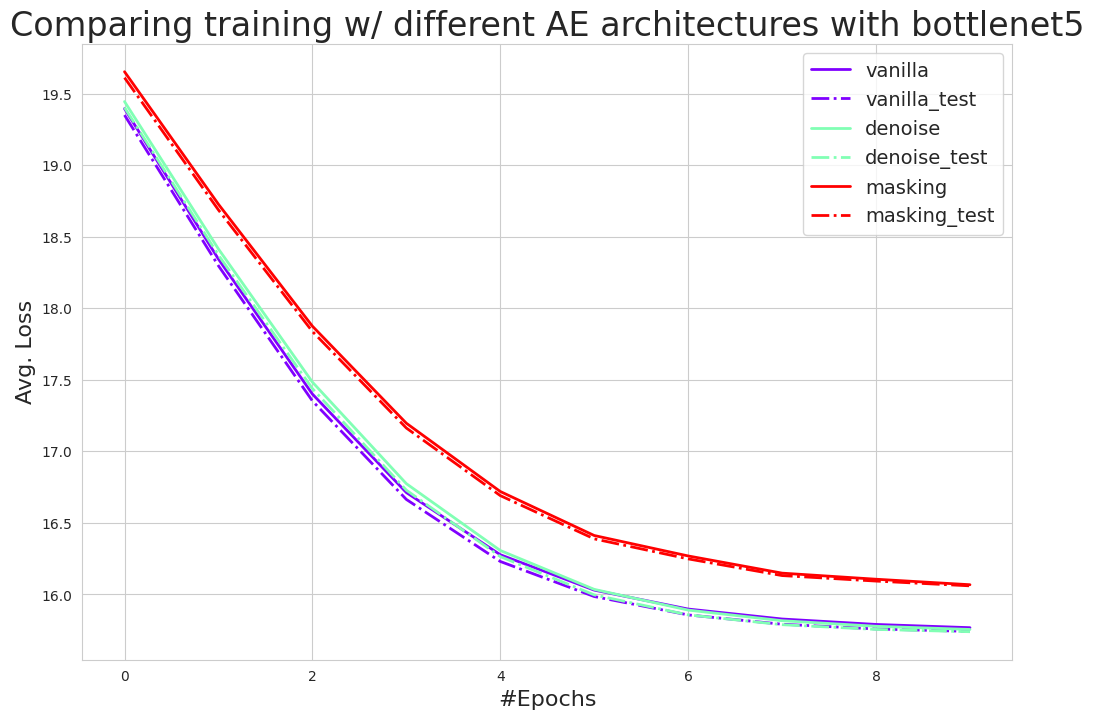

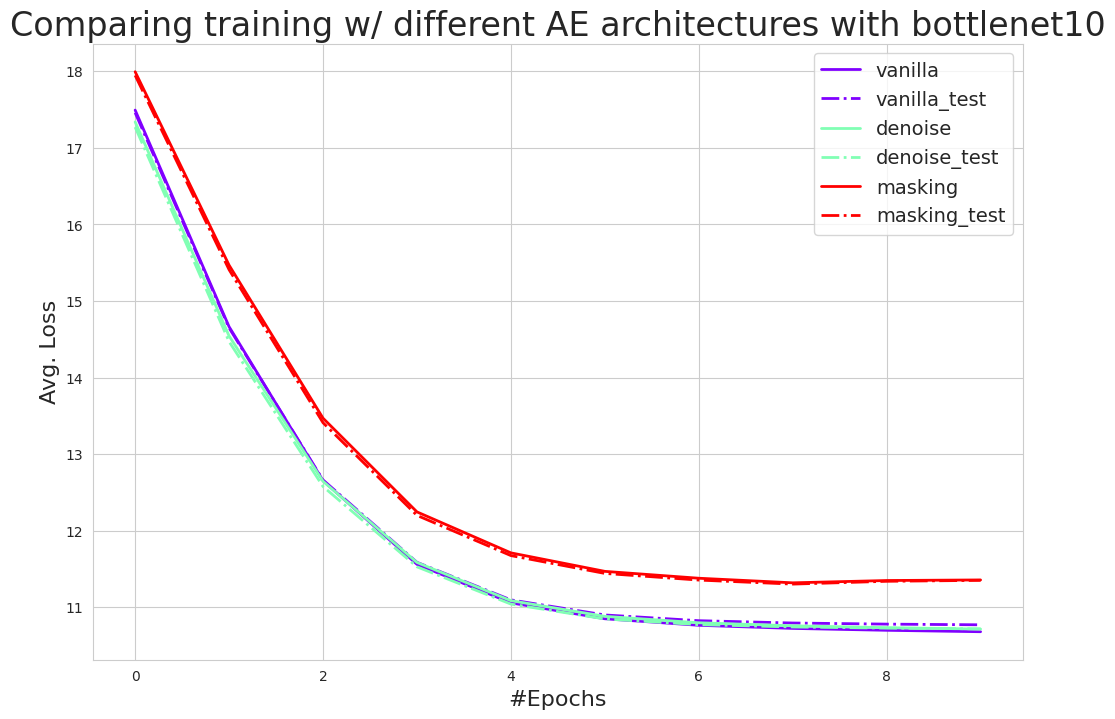

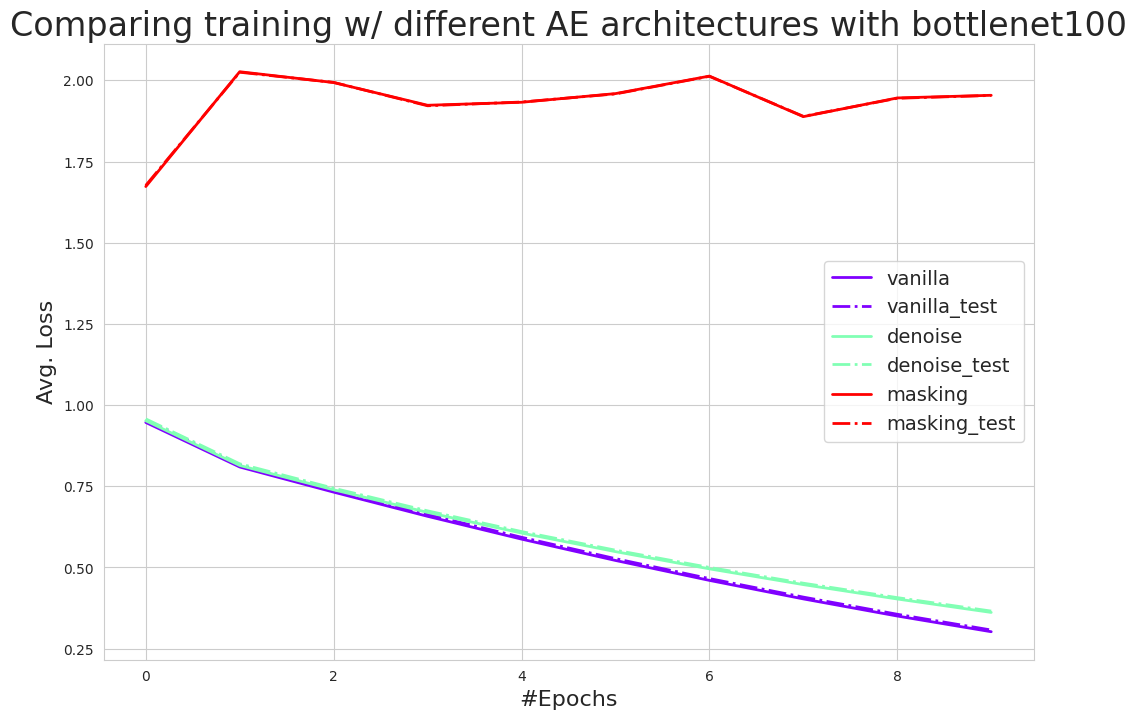

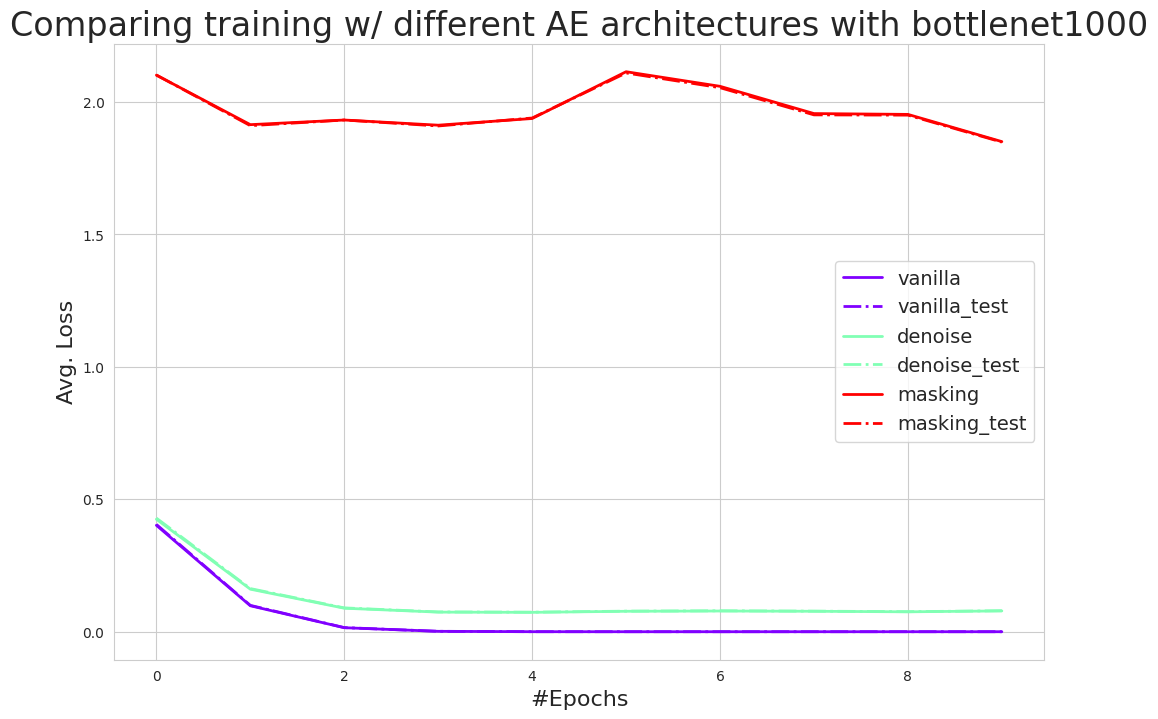

In [20]:
MODELS = {
    "vanilla": Autoencoder,
    "denoise": DenoisingAutoencoder,
    "masking": MaskedAutoencoder,
}

# we repeat each experiment and report mean performance
NUM_REPEATS = 3
NUM_EPOCHS = 10
BATCH_SIZE = 100

# load and create Synthetic dataset
INPUT_DIMS = 100
NUM_SAMPLES = 20000
DATA_SPLITS = [0.7, 0.2, 0.1]  # train, valid, test
NUM_HIGH_VAR_DIMS = 20
VAR_SCALE = 100
NUM_CLASSES = 2
dataset = SyntheticDataset(
    INPUT_DIMS, NUM_SAMPLES, DATA_SPLITS, NUM_HIGH_VAR_DIMS, VAR_SCALE, BATCH_SIZE)

##########################################
####### TODO : define model architecture 
# hidden dims is a list of ints 
HIDDEN_DIMS_LIST = [[5],[10], [100], [1000]]
ACTIVATION = nn.Identity()
##########################################

# logging metrics


# run experiment w/ different models
for HIDDEN_DIMS in HIDDEN_DIMS_LIST:
    print("Now, bottleneck is ", f'{HIDDEN_DIMS}')
    feats_dim = HIDDEN_DIMS[-1]
    train_losses, test_losses = {}, {}
    accuracy = {}
    for model_idx, model_cls in MODELS.items():
        _train_loss, _valid_loss, _acc = [], [], []
        for expid in range(NUM_REPEATS):
            print("run : {},  model : {}".format(expid, model_idx))
            model = model_cls(INPUT_DIMS, HIDDEN_DIMS, activation=ACTIVATION)
            experiment = Experiment(dataset, model)
            train_stats = experiment.train(num_epochs=NUM_EPOCHS)
            eval_stats = experiment.evaluate_w_linear_probe(feats_dim, NUM_EPOCHS)
            _train_loss.append(train_stats["train_losses"])
            _valid_loss.append(train_stats["valid_losses"])
            _acc.append(eval_stats["accuracy"])
        
        train_losses[model_idx] = np.mean(_train_loss, axis=0)
        test_losses[model_idx] = np.mean(_valid_loss, axis=0)
        accuracy[model_idx] = np.mean(_acc)

    # plot losses
    plotter(train_losses, test_losses, HIDDEN_DIMS[0])

    # report accuracy
    for model_idx, acc in accuracy.items():
        print("Model : {}, Accuracy : {}".format(model_idx, acc))

## Nonlinear AutoEncoders on Synthetic Dataset

Train a nonlinear autoencoder with different bottleneck sizes (5, 10, 100, 1000) and report performance of each architecture on the synthetic dataset.

Now, bottleneck is  [5]
run : 0,  model : vanilla


Epoch 9, Loss 0.5426: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.7229: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.6299: 100%|██████████| 10/10 [00:00<00:00, 15.29it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.6674: 100%|██████████| 10/10 [00:00<00:00, 14.22it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.6158: 100%|██████████| 10/10 [00:00<00:00, 14.97it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.6921: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s]


run : 0,  model : masking


Epoch 9, Loss 0.6439: 100%|██████████| 10/10 [00:00<00:00, 15.70it/s]


run : 1,  model : masking


Epoch 9, Loss 0.6296: 100%|██████████| 10/10 [00:00<00:00, 16.52it/s]


run : 2,  model : masking


Epoch 9, Loss 0.6080: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


Model : vanilla, Accuracy : 0.6703333333333333
Model : denoise, Accuracy : 0.6253333333333333
Model : masking, Accuracy : 0.6515
Now, bottleneck is  [10]
run : 0,  model : vanilla


Epoch 9, Loss 0.4147: 100%|██████████| 10/10 [00:00<00:00, 15.57it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.4836: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.4456: 100%|██████████| 10/10 [00:00<00:00, 17.00it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.5815: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.4207: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.4479: 100%|██████████| 10/10 [00:00<00:00, 14.29it/s]


run : 0,  model : masking


Epoch 9, Loss 0.5098: 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]


run : 1,  model : masking


Epoch 9, Loss 0.5142: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


run : 2,  model : masking


Epoch 9, Loss 0.4451: 100%|██████████| 10/10 [00:00<00:00, 16.19it/s]


Model : vanilla, Accuracy : 0.767
Model : denoise, Accuracy : 0.7360000000000001
Model : masking, Accuracy : 0.7356666666666666
Now, bottleneck is  [100]
run : 0,  model : vanilla


Epoch 9, Loss 0.0732: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.1017: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.0818: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.0871: 100%|██████████| 10/10 [00:00<00:00, 13.76it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.0856: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.0986: 100%|██████████| 10/10 [00:00<00:00, 15.24it/s]


run : 0,  model : masking


Epoch 9, Loss 0.0940: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]


run : 1,  model : masking


Epoch 9, Loss 0.1016: 100%|██████████| 10/10 [00:00<00:00, 14.50it/s]


run : 2,  model : masking


Epoch 9, Loss 0.1026: 100%|██████████| 10/10 [00:00<00:00, 14.80it/s]


Model : vanilla, Accuracy : 0.9788333333333332
Model : denoise, Accuracy : 0.9834999999999999
Model : masking, Accuracy : 0.9845
Now, bottleneck is  [1000]
run : 0,  model : vanilla


Epoch 9, Loss 0.0436: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


run : 1,  model : vanilla


Epoch 9, Loss 0.0434: 100%|██████████| 10/10 [00:01<00:00,  9.61it/s]


run : 2,  model : vanilla


Epoch 9, Loss 0.0386: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


run : 0,  model : denoise


Epoch 9, Loss 0.0380: 100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


run : 1,  model : denoise


Epoch 9, Loss 0.0376: 100%|██████████| 10/10 [00:01<00:00,  9.27it/s]


run : 2,  model : denoise


Epoch 9, Loss 0.0439: 100%|██████████| 10/10 [00:00<00:00, 10.16it/s]


run : 0,  model : masking


Epoch 9, Loss 0.0396: 100%|██████████| 10/10 [00:00<00:00, 10.46it/s]


run : 1,  model : masking


Epoch 9, Loss 0.0482: 100%|██████████| 10/10 [00:00<00:00, 10.57it/s]


run : 2,  model : masking


Epoch 9, Loss 0.0458: 100%|██████████| 10/10 [00:01<00:00,  9.99it/s]


Model : vanilla, Accuracy : 0.9808333333333333
Model : denoise, Accuracy : 0.9791666666666666
Model : masking, Accuracy : 0.9795000000000001


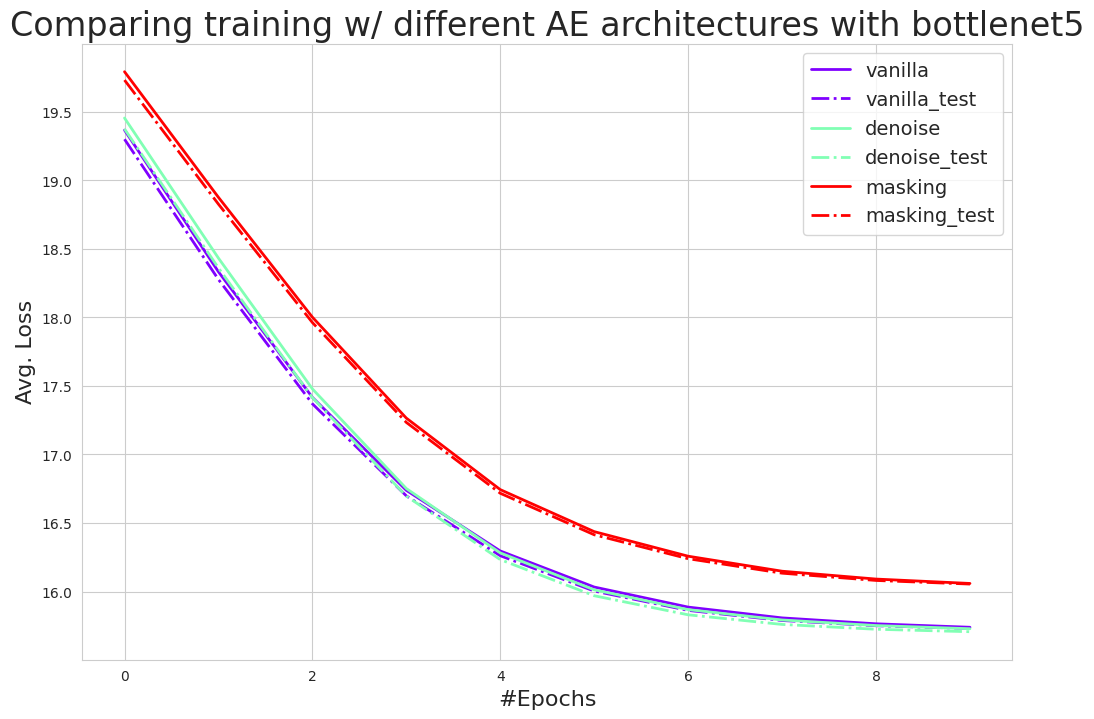

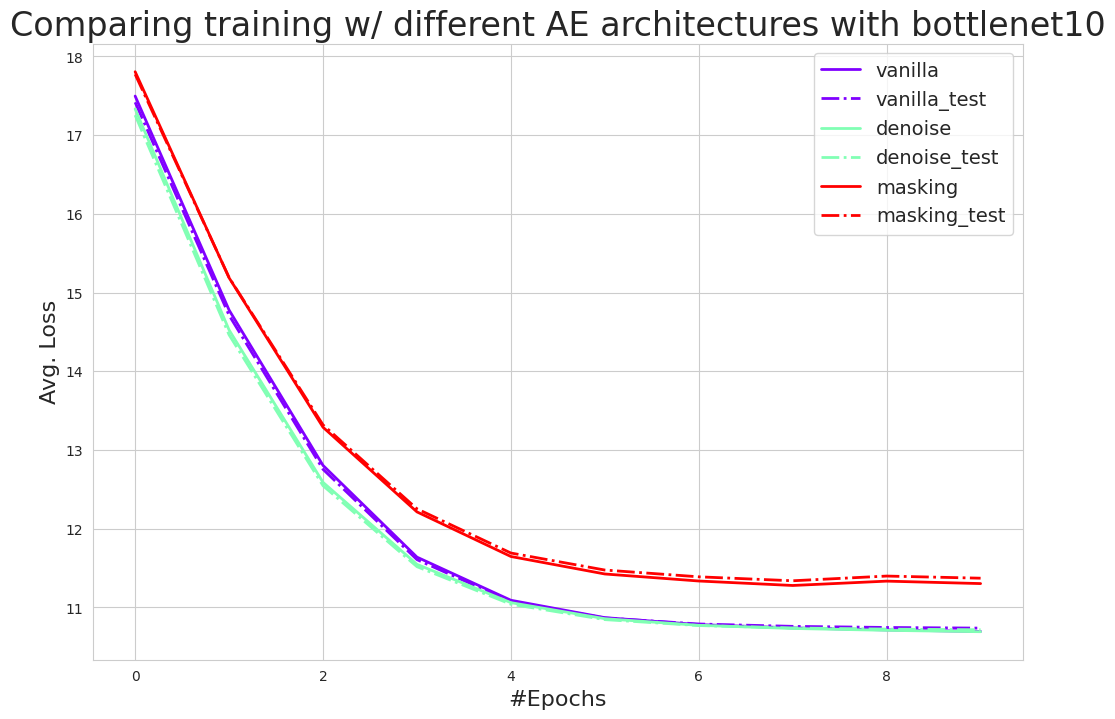

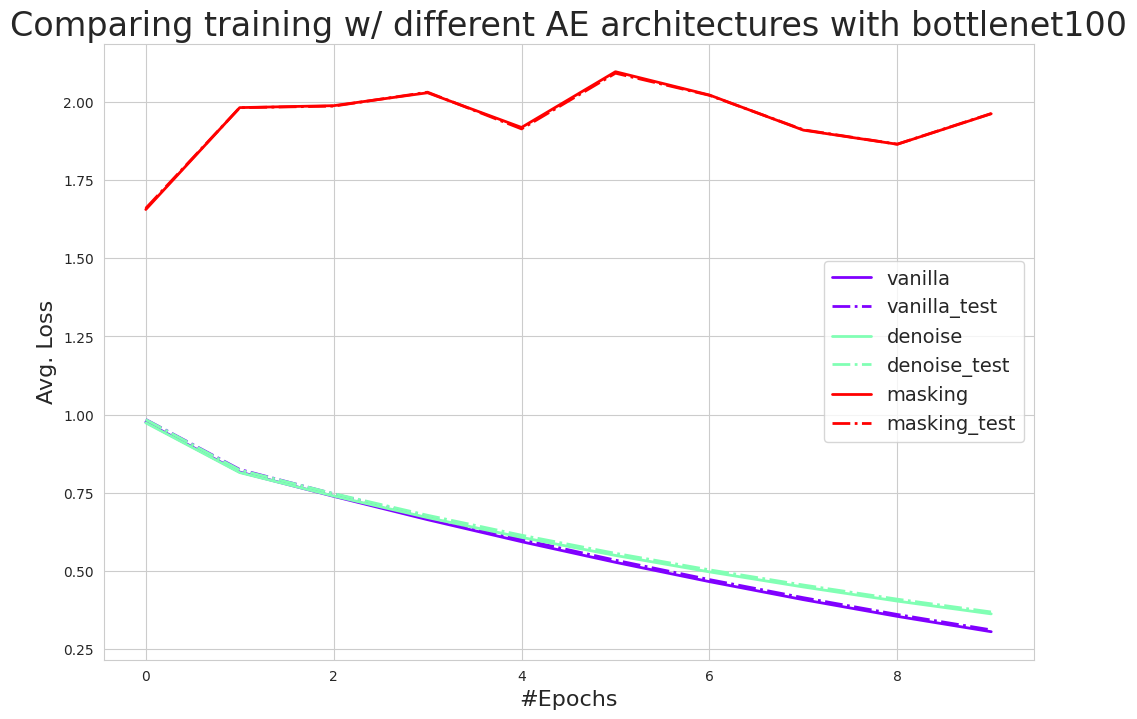

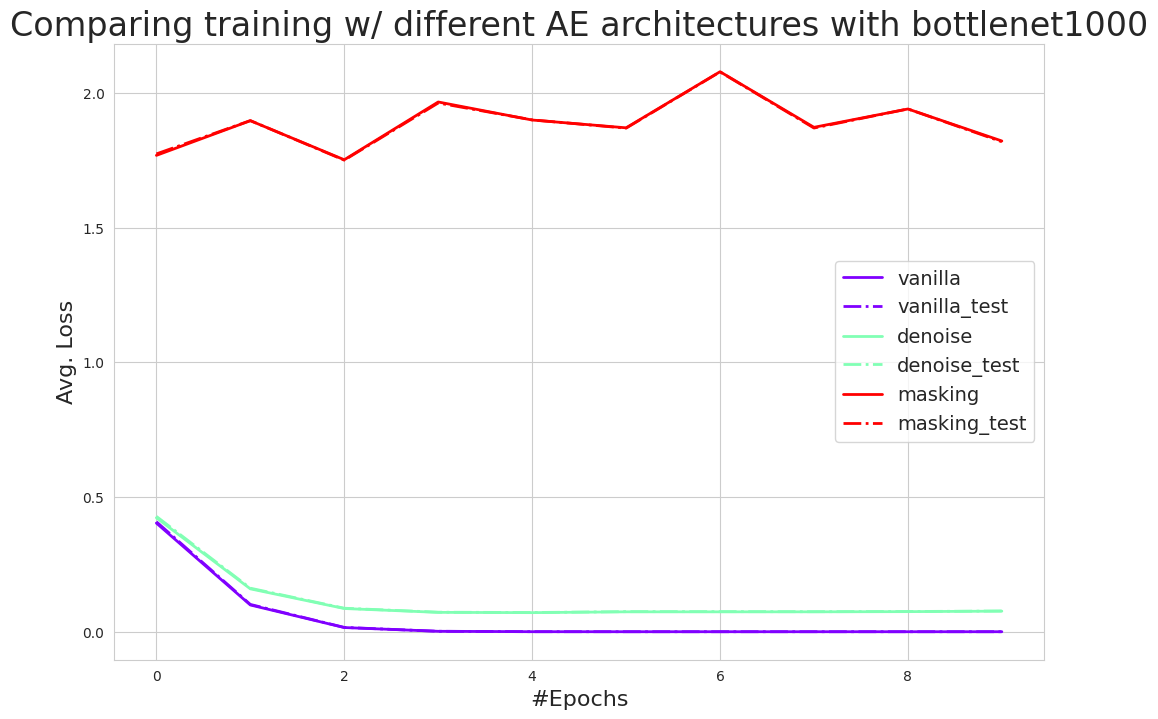

In [24]:
MODELS = {
    "vanilla": Autoencoder,
    "denoise": DenoisingAutoencoder,
    "masking": MaskedAutoencoder,
}

NUM_REPEATS = 3
NUM_EPOCHS = 10
BATCH_SIZE = 100

# load and create Synthetic dataset
INPUT_DIMS = 100
NUM_SAMPLES = 20000
DATA_SPLITS = [0.7, 0.2, 0.1]  # train, valid, test
NUM_HIGH_VAR_DIMS = 20
VAR_SCALE = 100
NUM_CLASSES = 2
dataset = SyntheticDataset(
    INPUT_DIMS, NUM_SAMPLES, DATA_SPLITS, NUM_HIGH_VAR_DIMS, VAR_SCALE, BATCH_SIZE)

##########################################
####### TODO : define model architecture 
# hidden dims is a list of ints
HIDDEN_DIMS = [[5],[10], [100], [1000]]
ACTIVATION = nn.ReLU()
##########################################

# logging metrics
feats_dim = HIDDEN_DIMS[-1]
train_losses, test_losses = {}, {}
accuracy = {}

# run experiment w/ different models
for HIDDEN_DIMS in HIDDEN_DIMS_LIST:
    print("Now, bottleneck is ", f'{HIDDEN_DIMS}')
    feats_dim = HIDDEN_DIMS[-1]
    train_losses, test_losses = {}, {}
    accuracy = {}
    for model_idx, model_cls in MODELS.items():
        _train_loss, _valid_loss, _acc = [], [], []
        for expid in range(NUM_REPEATS):
            print("run : {},  model : {}".format(expid, model_idx))
            model = model_cls(INPUT_DIMS, HIDDEN_DIMS, activation=ACTIVATION)
            experiment = Experiment(dataset, model)
            train_stats = experiment.train(num_epochs=NUM_EPOCHS)
            eval_stats = experiment.evaluate_w_linear_probe(feats_dim, NUM_EPOCHS)
            _train_loss.append(train_stats["train_losses"])
            _valid_loss.append(train_stats["valid_losses"])
            _acc.append(eval_stats["accuracy"])
        
        train_losses[model_idx] = np.mean(_train_loss, axis=0)
        test_losses[model_idx] = np.mean(_valid_loss, axis=0)
        accuracy[model_idx] = np.mean(_acc)

    # plot losses
    plotter(train_losses, test_losses, HIDDEN_DIMS[0])

    # report accuracy
    for model_idx, acc in accuracy.items():
        print("Model : {}, Accuracy : {}".format(model_idx, acc))

## Linear AutoEncoders on MNIST

Train a linear autoencoder with different bottleneck sizes (5, 10, 100, 1000)
and report performance of each architecture.

In [33]:
MODELS = {
    "VANILLA AE": Autoencoder,
    "DENOISING AE": DenoisingAutoencoder,
    "MASKED AE": MaskedAutoencoder,
}

NUM_REPEATS = 3
NUM_EPOCHS = 10
BATCH_SIZE = 200

##########################################
####### TODO : define model architecture 
# hidden dims is a list of ints
INPUT_DIMS = 784
NUM_CLASSES = 10
ACTIVATION = nn.Identity()
HIDDEN_DIMS_LIST = [[5],[10],[100],[1000]]
##########################################

# load and create MNIST dataset
dataset = MNIST(BATCH_SIZE, [0.6, 0.4])
for HIDDEN_DIMS in HIDDEN_DIMS_LIST:
# logging metrics
    feats_dim = HIDDEN_DIMS[-1]
    train_losses, test_losses = {}, {}
    accuracy = {}

    # run experiment w/ different models
    for model_idx, model_cls in MODELS.items():
        _train_loss, _valid_loss, _acc = [], [], []
        for expid in range(NUM_REPEATS):
            print("run : {},  model : {}".format(expid, model_idx))
            model = model_cls(INPUT_DIMS, HIDDEN_DIMS, activation=ACTIVATION)
            experiment = Experiment(dataset, model, num_classes=NUM_CLASSES)
            train_stats = experiment.train(num_epochs=NUM_EPOCHS)
            eval_stats = experiment.evaluate_w_linear_probe(feats_dim, NUM_EPOCHS)
            _train_loss.append(train_stats["train_losses"])
            _valid_loss.append(train_stats["valid_losses"])
            _acc.append(eval_stats["accuracy"])
        
        train_losses[model_idx] = np.mean(_train_loss, axis=0)
        test_losses[model_idx] = np.mean(_valid_loss, axis=0)
        accuracy[model_idx] = np.mean(_acc)

    # plot losses
    plotter(train_losses, test_losses, HIDDEN_DIMS)

    # report accuracy
    for model_idx, acc in accuracy.items():
        print("Model : {}, Accuracy : {}".format(model_idx, acc))

run : 0,  model : VANILLA AE


Epoch 2, Loss 2.0645:  20%|██        | 2/10 [00:12<00:50,  6.32s/it]


KeyboardInterrupt: 

## Nonlinear dimensionality reduction on MNIST

Train a nonlinear autoencoder with different bottleneck sizes e.g. (5, 10, 100, 1000) and report performance of your choice of architecture on the MNIST dataset.



run : 0,  model : VANILLA AE


Epoch 9, Loss 1.4308: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 1.5548: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 1.5022: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


run : 3,  model : VANILLA AE


Epoch 9, Loss 1.4817: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


run : 4,  model : VANILLA AE


Epoch 9, Loss 1.4379: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 1.2674: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 1.4679: 100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 1.4292: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


run : 3,  model : DENOISING AE


Epoch 9, Loss 1.4310: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


run : 4,  model : DENOISING AE


Epoch 9, Loss 1.4869: 100%|██████████| 10/10 [00:45<00:00,  4.50s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 1.3933: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 1.4756: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 1.4318: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


run : 3,  model : MASKED AE


Epoch 9, Loss 1.3628: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


run : 4,  model : MASKED AE


Epoch 9, Loss 1.4076: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Model : VANILLA AE, Accuracy : 0.576
Model : DENOISING AE, Accuracy : 0.569
Model : MASKED AE, Accuracy : 0.5880000000000001
run : 0,  model : VANILLA AE


Epoch 9, Loss 0.9362: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 0.8695: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 0.8472: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


run : 3,  model : VANILLA AE


Epoch 9, Loss 0.9379: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


run : 4,  model : VANILLA AE


Epoch 9, Loss 0.8063: 100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 0.7780: 100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 0.9001: 100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 0.8289: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


run : 3,  model : DENOISING AE


Epoch 9, Loss 0.8126: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


run : 4,  model : DENOISING AE


Epoch 9, Loss 0.8262: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 0.9110: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 0.8512: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 0.8282: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


run : 3,  model : MASKED AE


Epoch 9, Loss 0.8605: 100%|██████████| 10/10 [00:45<00:00,  4.50s/it]


run : 4,  model : MASKED AE


Epoch 9, Loss 0.9628: 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


Model : VANILLA AE, Accuracy : 0.749
Model : DENOISING AE, Accuracy : 0.742
Model : MASKED AE, Accuracy : 0.74
run : 0,  model : VANILLA AE


Epoch 9, Loss 0.3476: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 0.2538: 100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 0.4518: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


run : 3,  model : VANILLA AE


Epoch 9, Loss 0.3742: 100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


run : 4,  model : VANILLA AE


Epoch 9, Loss 0.4893: 100%|██████████| 10/10 [00:49<00:00,  4.98s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 0.2881: 100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 0.3642: 100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 0.4374: 100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


run : 3,  model : DENOISING AE


Epoch 9, Loss 0.3922: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


run : 4,  model : DENOISING AE


Epoch 9, Loss 0.3062: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 0.3236: 100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 0.3744: 100%|██████████| 10/10 [00:50<00:00,  5.00s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 0.2818: 100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


run : 3,  model : MASKED AE


Epoch 9, Loss 0.2823: 100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


run : 4,  model : MASKED AE


Epoch 9, Loss 0.3429: 100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


Model : VANILLA AE, Accuracy : 0.95
Model : DENOISING AE, Accuracy : 0.945
Model : MASKED AE, Accuracy : 0.959
run : 0,  model : VANILLA AE


Epoch 9, Loss 0.3585: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 0.1642: 100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 0.3131: 100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


run : 3,  model : VANILLA AE


Epoch 9, Loss 0.1881: 100%|██████████| 10/10 [01:10<00:00,  7.04s/it]


run : 4,  model : VANILLA AE


Epoch 9, Loss 0.2437: 100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 0.2778: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 0.2189: 100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 0.2870: 100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


run : 3,  model : DENOISING AE


Epoch 9, Loss 0.3865: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


run : 4,  model : DENOISING AE


Epoch 9, Loss 0.3566: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 0.2824: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 0.2655: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 0.2590: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


run : 3,  model : MASKED AE


Epoch 9, Loss 0.2004: 100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


run : 4,  model : MASKED AE


Epoch 9, Loss 0.3288: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


Model : VANILLA AE, Accuracy : 0.9650000000000001
Model : DENOISING AE, Accuracy : 0.9629999999999999
Model : MASKED AE, Accuracy : 0.9639999999999999


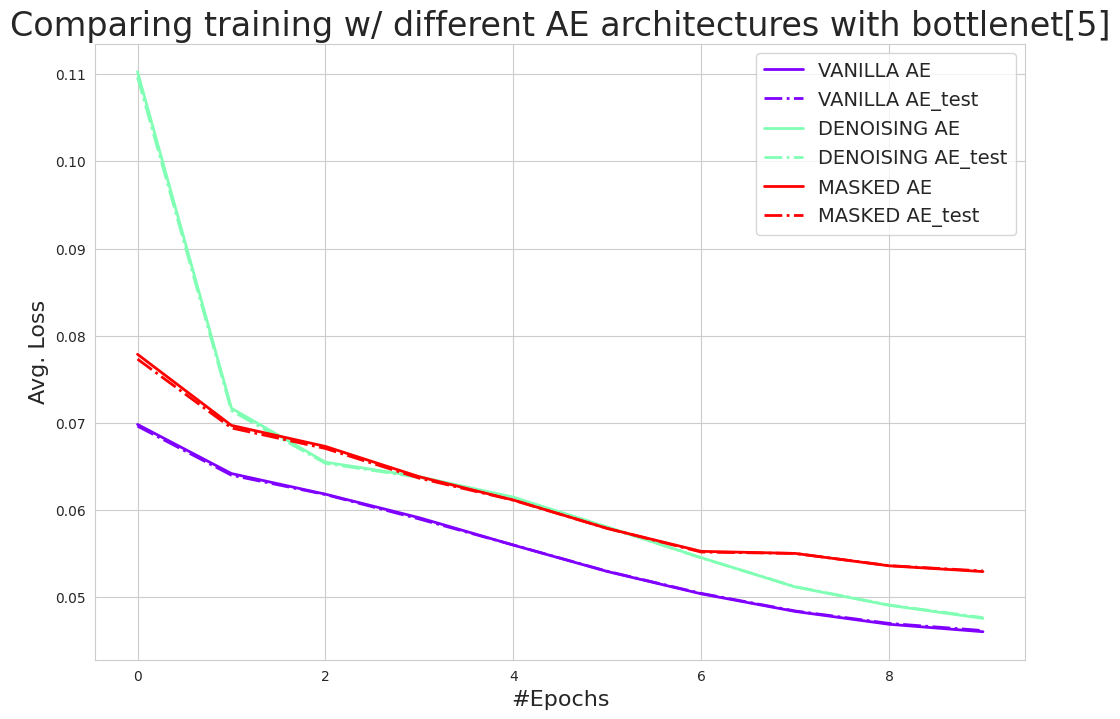

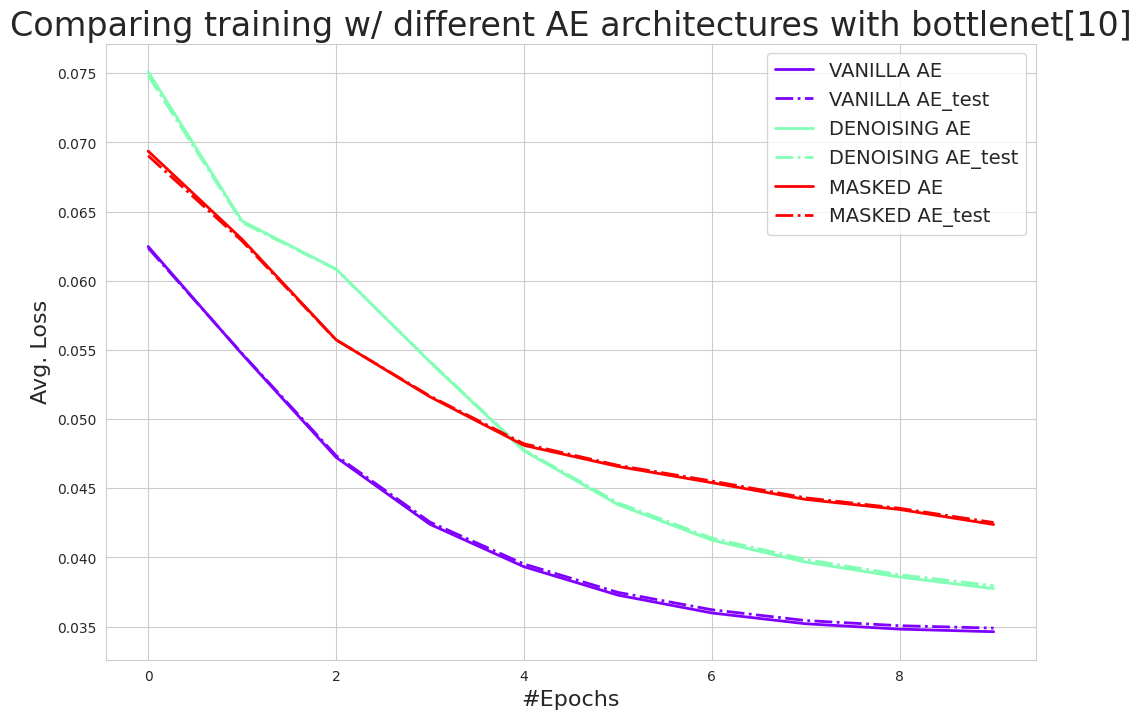

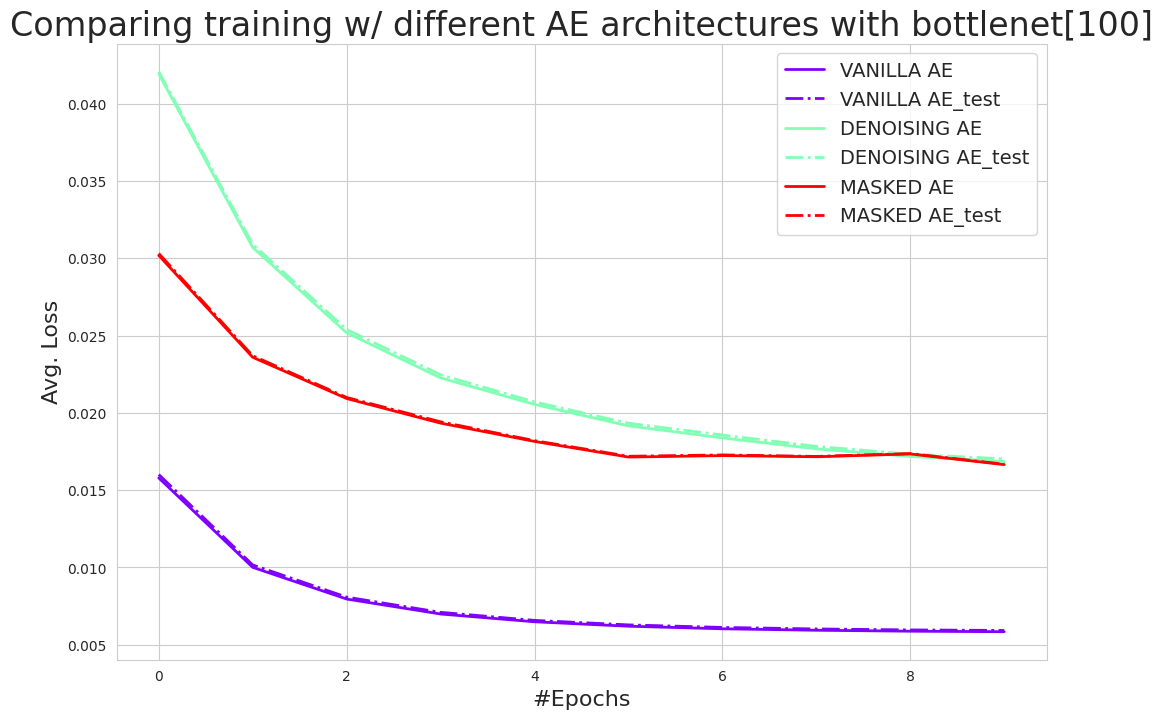

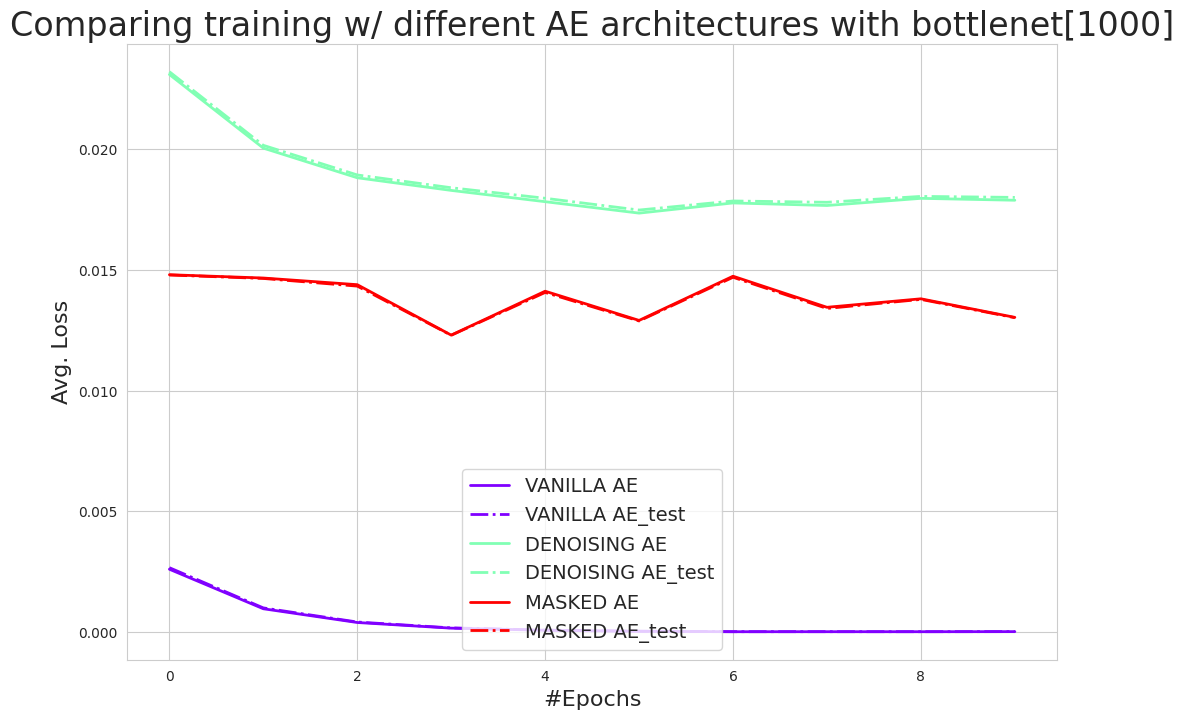

In [32]:
MODELS = {
    "VANILLA AE": Autoencoder,
    "DENOISING AE": DenoisingAutoencoder,
    "MASKED AE": MaskedAutoencoder,
}

NUM_REPEATS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 200

##########################################
####### TODO : define model architecture 
# hidden dims is a list of ints
INPUT_DIMS = 784
NUM_CLASSES = 10
ACTIVATION = nn.ReLU()
HIDDEN_DIMS_LIST = [[5],[10], [100], [1000]]
##########################################

# load and create MNIST dataset
dataset = MNIST(BATCH_SIZE, [0.6, 0.4])
for HIDDEN_DIMS in HIDDEN_DIMS_LIST:
# logging metrics
    feats_dim = HIDDEN_DIMS[-1]
    train_losses, test_losses = {}, {}
    accuracy = {}

    # run experiment w/ different models
    for model_idx, model_cls in MODELS.items():
        _train_loss, _valid_loss, _acc = [], [], []
        for expid in range(NUM_REPEATS):
            print("run : {},  model : {}".format(expid, model_idx))
            model = model_cls(INPUT_DIMS, HIDDEN_DIMS, activation=ACTIVATION)
            experiment = Experiment(dataset, model, num_classes=NUM_CLASSES)
            train_stats = experiment.train(num_epochs=NUM_EPOCHS)
            eval_stats = experiment.evaluate_w_linear_probe(feats_dim, NUM_EPOCHS)
            _train_loss.append(train_stats["train_losses"])
            _valid_loss.append(train_stats["valid_losses"])
            _acc.append(eval_stats["accuracy"])
        
        train_losses[model_idx] = np.mean(_train_loss, axis=0)
        test_losses[model_idx] = np.mean(_valid_loss, axis=0)
        accuracy[model_idx] = np.mean(_acc)

    # plot losses
    plotter(train_losses, test_losses, HIDDEN_DIMS)

    # report accuracy
    for model_idx, acc in accuracy.items():
        print("Model : {}, Accuracy : {}".format(model_idx, acc))